In [10]:
#1. Загрузка библиотек

In [1]:
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import yake
import spacy

morph = MorphAnalyzer()
stop_words = stopwords.words('russian')

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.g

In [2]:
#2. Загрузка датафрейма и предобработка текста

In [3]:
SecurityLab = pd.read_csv("SecurityLab(8000).csv", encoding = "UTF-8", sep = ",")
full_texts = list(SecurityLab["Text"])

In [4]:
def preprocess(text):
    tokens = wordpunct_tokenize(text)
    lemmatized = [morph.parse(item)[0].normal_form for item in tokens]
    lemmatized = [token for token in lemmatized if token.isalpha()]
    lemmatized = [token for token in lemmatized if len(token) > 1]
    clean_text = [word for word in lemmatized if word not in stop_words]
    return clean_text

In [5]:
preprocessed_texts = [preprocess(text) for text in tqdm(full_texts)]

100%|██████████████████████████████████████████████████████████████████████████████| 8009/8009 [04:37<00:00, 28.87it/s]


In [6]:
#3. Тематическое моделирование предобработанного текста

In [6]:
#превратить список текстов в специальный объект для библиотеки Gensim
gensim_dictionary_for_TM = gensim.corpora.Dictionary(preprocessed_texts)

# удалить из корпуса слова:
# которые встречаются более чем в 10% документах корпуса (no_above=0.1)
# и менее чем в 20 документах (no_below=20)
gensim_dictionary_for_TM.filter_extremes(no_above=0.1, no_below=20)

# сжать словарь после того, как убраны лишние слова
gensim_dictionary_for_TM.compactify()

# посмотреть словарь
print(gensim_dictionary_for_TM)

#преобразовать тексты в bags of words
corpus = [gensim_dictionary_for_TM.doc2bow(text) for text in preprocessed_texts]

Dictionary<4834 unique tokens: ['android', 'apk', 'app', 'apple', 'galaxy']...>


In [20]:
# обучение модели для тематического моделирования
lda = gensim.models.LdaMulticore(corpus,
                                 num_topics = 12, # число тем
                                 id2word=gensim_dictionary_for_TM, 
                                 passes=40, random_state=15)

In [98]:
#4. Визуализация тематического распределения по корпусу

In [21]:
#просмотреть выделенные темы
lda.print_topics(12)

[(0,
  '0.011*"technologies" + 0.011*"positive" + 0.009*"pt" + 0.007*"уровень" + 0.006*"рост" + 0.006*"исследование" + 0.005*"квартал" + 0.005*"обнаружение" + 0.005*"сравнение" + 0.005*"предприятие"'),
 (1,
  '0.014*"ия" + 0.010*"интеллект" + 0.010*"искусственный" + 0.009*"изображение" + 0.008*"модель" + 0.008*"исследование" + 0.006*"квантовый" + 0.006*"алгоритм" + 0.006*"обучение" + 0.006*"университет"'),
 (2,
  '0.031*"криптовалюта" + 0.016*"кошелёк" + 0.011*"транзакция" + 0.011*"сумма" + 0.011*"криптовалютный" + 0.010*"доллар" + 0.010*"биржа" + 0.009*"twitter" + 0.009*"токен" + 0.008*"блокчейн"'),
 (3,
  '0.009*"закон" + 0.009*"рф" + 0.008*"минцифра" + 0.007*"информационный" + 0.006*"требование" + 0.006*"запретить" + 0.006*"ведомство" + 0.006*"роскомнадзор" + 0.006*"право" + 0.006*"контент"'),
 (4,
  '0.015*"кампания" + 0.011*"фишинговый" + 0.009*"письмо" + 0.008*"вредонос" + 0.007*"домен" + 0.006*"полезный" + 0.006*"нагрузка" + 0.006*"загрузка" + 0.006*"троян" + 0.006*"бэкдора"'),


In [22]:
vis = gensimvis.prepare(lda, corpus, gensim_dictionary_for_TM)
pyLDAvis.enable_notebook()
vis

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.165240  0.098198       1        1  10.923533
1      0.029013 -0.102002       2        1   8.585817
14     0.119369  0.027268       3        1   8.427841
13    -0.164752  0.000601       4        1   8.421537
9      0.228266  0.028483       5        1   8.250560
3     -0.132903 -0.105405       6        1   7.813973
0      0.071797 -0.141273       7        1   7.373511
6     -0.172178  0.120200       8        1   5.940585
11    -0.123146  0.060666       9        1   5.763719
10     0.168560 -0.029321      10        1   5.225741
5     -0.007080  0.126232      11        1   5.213483
7     -0.024017 -0.187748      12        1   4.995020
8     -0.014950  0.153868      13        1   4.850529
2     -0.065075  0.085281      14        1   4.183808
12    -0.078144 -0.135048      15        1   4.030345, topic_info=                Term         Freq        Total Category  logprob  loglift
143              cve  2117.000000  2117.000000  Default  30.0000  30.0000
160       вымогатель  1734.000000  1734.000000  Default  29.0000  29.0000
3116  вымогательский  1392.000000  1392.000000  Default  28.0000  28.0000
804     криптовалюта  1065.000000  1065.000000  Default  27.0000  27.0000
3              apple  1437.000000  1437.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
524           против    99.548201   749.368953  Topic15  -5.7032   1.1927
1277         станция    87.487957   262.940413  Topic15  -5.8323   2.1109
1458     предприятие    91.024433   676.422798  Topic15  -5.7927   1.2056
103      программный    92.389964  1174.627769  Topic15  -5.7778   0.6686
948         источник    90.520366   745.996100  Topic15  -5.7982   1.1022

[969 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1535      1  0.019252        ad
1535      3  0.077008        ad
1535      4  0.038504        ad
1535      5  0.211773        ad
1535     10  0.654570        ad
...     ...       ...       ...
423      11  0.073809      язык
423      12  0.024603      язык
423      13  0.005678      язык
423      15  0.005678      язык
1680      2  0.982296  языковой

[5250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 15, 14, 10, 4, 1, 7, 12, 11, 6, 8, 9, 3, 13])

In [12]:
#5. Наименование тегов пользователем

In [16]:
# функция для форматирования словаря тем
topic_names_dict = {}

def name_topics(number):
    for i in range(number):
        temp = input("введите название темы "+str(i))
        topic_names_dict[i] = temp
    return topic_names_dict

In [ ]:
# создание словаря тем
# параметр должен совпадать с количеством тем (num_topics)
name_topics(12)

In [13]:
# сохранённый результат для 12 тем
topic_names_dict={0:"исследования", 1:"разработка и техника", 2:"финансы и бизнес", 3:"госрегулирование", 4:"вредоносы", 5:"мошенничества", 6:"законы и нарушения", 7:"события и мероприятия", 8:"программное обеспечение", 9:"уязвимости", 10:"утечки и обновления", 11:"кибербезопасность"}

In [ ]:
#6. Выделение тегов именованных сущностей

In [24]:
# функция выделения именованных сущностей
entities_dict = {}
def get_ner(text_list):
    nlp = spacy.load("ru_core_news_sm")
    for i in tqdm(range(len(full_texts))):
        doc = nlp(full_texts[i])
        temp=[]
        for ent in doc.ents:
            temp.append(ent.text)
            entities_dict[i]=temp
    return entities_dict

In [25]:
get_ner(full_texts)

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.g

{0: ['Apple',
  'Google',
  'Европе',
  'Атлантики',
  'Белого дома',
  'Apple',
  'Google',
  'Национальное управление телекоммуникаций и информации',
  'Министерства торговли (NTIA)',
  'Apple',
  'Apple',
  'Apple',
  'Apple',
  'App Store',
  'Европы',
  'США',
  'Apple',
  'Apple',
  'Samsung',
  'Huawei App Gallery',
  'Xiaomi GetApps',
  'RuStore',
  'Купертино',
  'Южная Корея',
  'Нидерланды',
  'Apple',
  'Google',
  'Евросоюз',
  'Apple'],
 1: ['Lazarus Group',
  'Zimbra',
  'WithSecure',
  'No Pineapple',
  'Zimbra',
  'WithSecure',
  'Dtrack',
  'GREASE',
  'GREASE',
  'Северной Кореей',
  'Kimsuky',
  'Dtrack',
  'Maui',
  'C2-сервер',
  'Cisco Talos',
  'Lazarus Group',
  'Северной Кореей',
  'КНДР'],
 2: ['Лаборатории Касперского', 'Лаборатория Касперского'],
 3: ['Евросоюз',
  'ЕС',
  'Норвегия',
  'Исландия',
  'Еврокомиссии',
  'Дидье Рейндерса',
  'Дидье',
  'Еврокомиссия',
  'Европейский совет по защите данных (EDPB)',
  'Евросоюзе'],
 4: ['LockBit',
  'LockBit',
 

In [26]:
# функция нормализации именованных сущностей
def preprocess_ent(entities_dict):
    lemmatized = [morph.parse(item)[0].normal_form for item in entities_dict]
    lemmatized = [token for token in lemmatized if token.isalpha()]
    lemmatized = [token for token in lemmatized if len(token) > 3]
    return lemmatized

In [27]:
# создание словаря уникальных токенов с помощью множества
unified_dict = {}
for(i) in range(len(entities_dict.values())):  
    try:
        a = list(set(entities_dict[i]))
        unified_dict[i] = a
    except:
        unified_dict[i] = []

# нормализация токенов и создание словаря нормализованных токенов
normalized_dict = {}
for i in range(len(unified_dict.values())):
    normalized_dict[i] = list(set(preprocess_ent(unified_dict[i])))

# создание счетчика токенов 
counter_dict = {}
for i in normalized_dict.values():
    for a in i:
        counter_dict[a] = counter_dict.get(a, 0) + 1

# токены в словаре фильтруются по частотным показателям
clear_list = []
for i in counter_dict.items():
    if i[1] >= (0.001*len(full_texts)):
        clear_list.append(i[0])

# токены именованных сущностей в готовом виде записываются в словарь        
name_tags={}
for k, v  in normalized_dict.items():
    temp_list = []
    for i in v:
        if i in clear_list:
            temp_list.append(i.capitalize())
    name_tags[k]=(temp_list)

In [28]:
#6. Извлечение ключевых слов

In [29]:
# создание объекта Yake
extractor = yake.KeywordExtractor(
lan= "ru",
n = 1,
dedupLim = 0.3,
top = 10
)

In [30]:
# создание функции выделения ключевых слов
raw_keywords = []
def extract_kw(list):
    for text in list:
        yakelist = []
        for word in extractor.extract_keywords(text):
            yakelist.append(word[0])
        raw_keywords.append(yakelist)
    return raw_keywords

In [31]:
# создание функции нормализации ключевых слов
keywords = []
def preprocess_kw(list):
    for sublist in list:
        lemmatized = []
        lemmatized = [morph.parse(item)[0].normal_form for item in sublist]
        lemmatized = [token for token in lemmatized if token.isalpha()]
        lemmatized = [token for token in lemmatized if len(token) > 3]
        keywords.append(lemmatized)
    return keywords

In [32]:
raw_kw = extract_kw(full_texts)

In [33]:
keywords = preprocess_kw(raw_kw)

In [34]:
#7. Назначение новых тегов и сохранение корпуса

In [38]:
# выделение трех наиболее важных тем для каждого текста в корпусе и запись их в словарь
topic_dict={}
for a in range(len(preprocessed_texts)):
    temp_dict = zip([b[1] for b in lda.get_document_topics(corpus[a])],[b[0] for b in lda.get_document_topics(corpus[a])])
    top = sorted(temp_dict, reverse = True)[:3]
    top_topics = []
    for c in top:
        top_topics.append(topic_names_dict[c[1]])
    topic_dict[a]=top_topics

In [40]:
# сохранение результатов в датафрейм

texts = list(SecurityLab["Text"])
old_tags = list(SecurityLab["Tags"])
titles = list(SecurityLab["Title"])
subtitles = list(SecurityLab["Subtitle"])
news_links = list(SecurityLab["Unnamed: 0"])
topic_tags = list([i for i in topic_dict.values()])
ent_tags = list([i for i in name_tags.values()])
data_list = titles, subtitles, old_tags, topic_tags, ent_tags, keywords, texts
SecurityLab_df = pd.DataFrame(data_list, columns = news_links).T
SecurityLab_df = SecurityLab_df.rename(columns={0:"Title", 1:"Subtitle", 2:"Original_tags", 3:"Topic_tags", 4:"Name_tags",5:"Keywords", 6:"Text"})
SecurityLab_df.to_csv("ResultsAdd.csv", encoding="utf-8")

In [41]:
#8. Оценка результатов работы модели с помощью параметра Coherence score по метрике c_v

In [17]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda,
                                     texts=preprocessed_texts,
                                     dictionary=gensim_dictionary_for_TM,
                                     coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
 
print("\nCoherence Score: ", coherence_lda)


# оценка качества тематического моделирования по отношению к количеству тем, метрика c_v


Coherence Score:  0.5748972356294453


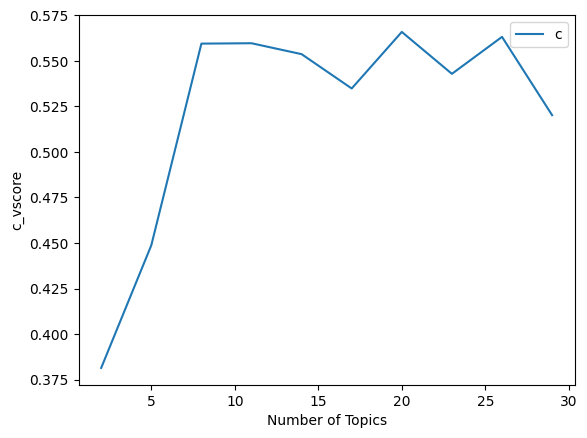

In [94]:
def coherence_score(dictionary, corpus, texts, max, start=2, step=3,
                    measure="c_uci"):

    coherence_values = []
    for num_topics in range(start, max, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, 
                                           passes=10, num_topics=num_topics, 
                                           random_state=15)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=measure)
        coherence_values.append(coherencemodel.get_coherence())
    x = range(start, max, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel(measure + "score")
    plt.legend(("coherence_score"), loc='best')
    plt.show()

coherence_score(dictionary=gensim_dictionary_for_TM, corpus=corpus, texts=preprocessed_texts, start=2, max=30, step=3, measure="c_v")